### Code source
https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_dataset')

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

import seaborn as sns
import matplotlib.patheffects as PathEffects

In [0]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, Activation, BatchNormalization, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

In [0]:
def mean_clip(x):
    mean = np.mean(x)
    return np.clip(x, mean-126, mean+127)

def low_clip(x):
    return np.clip(x, 255, 65535)

def minmax(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def max_normalise(x):
    max = np.max(x)
    return x / max

In [0]:
def is_dmso(file):
    # file format: folder/CKX - L - 00(...)

    # only file, no folder
    file = file.split('/')[-1].split("(")[0]

    # get letter for DMSO indices
    letter = file.split('-')[1].strip()

    # number
    label = file[-2:].strip()

    # cell case
    ck = file[:4]

    if ck == "CK19":
        if label in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
            return True
    elif ck == "CK21" or ck == "CK22":
        if label != 3 and letter in ["H", "P"]:
            return True
    else:
        print("No CK found")
    return False

In [0]:
def sliding_window(img, dest_size):
    new_img = np.full_like(img, img)

    size = img.shape[0]
    if dest_size > size or dest_size % 2 != 0:
        raise Exception("destination size is bigger than picture size or destination size is not even")

    qty = size//dest_size
    if size % dest_size != 0:
        # need to crop out the left and bottom (less significant in dataset)
        crop = size-dest_size*qty
        new_img = new_img[crop:, :-crop]

    windows = np.ndarray(shape=(qty**2, dest_size, dest_size), dtype=np.float32)

    i = 0
    for row in range(qty):
        y = row*dest_size
        x = 0
        for col in range(qty):
            #print("x:coord {},{} - y:coord {},{}".format(x, x+dest_size, y, y+dest_size))
            windows[i] = new_img[x:x+dest_size, y:y+dest_size]
            x += dest_size
            i += 1

    return windows

def get_label(filename):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: empty

    # filename format: folder/CKX - L - 00(...)
    file = filename.split("/")[-1].split("(")[0]

    # get letter for DMSO indices
    letter = file.split('-')[1].strip()

    # get number
    number = file[-2:].strip()

    # get plate layout number
    ck = file[:4]

    # DMSO = []

    if ck == "CK19":
        #if number in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
        #   DMSO.append(len(labels))
        if number in ["3", "4", "5", "6", "7", "8", "24"]:
            label = 0
        elif number in ["9", "10", "11", "13", "14", "15", "23"]:
            label = 1
        elif number in ["16", "17", "18", "19", "20", "21", "22"]:
            label = 2
        else:
            label = 3
    elif ck == "CK21" or ck == "CK22":
        if number in ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]:
            label = 0
        elif int(number) in range(14, 24):
            label = 2
        else:
            label = 3
        #if label != 3 and letter in ["H", "P"]:
        #    DMSO.append(len(labels))
    else:
        print("No CK found")
        return False

    return label

def even_round(num):
    return round(num/2.)*2

# need to find a way to shuffle this pairwise!
def dataset_split(dataset, labels, test_size=0.2):
    test_size = even_round(len(dataset)*test_size)
    x_train, x_test = dataset[:-test_size], dataset[-test_size:]
    y_train, y_test = labels[:-test_size], labels[-test_size:]
    return x_train, x_test, y_train, y_test
  
def unishuffle(a, b, random_state=RS):
    assert len(a) == len(b)
    if random_state:
      np.random.seed(RS)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
def show_image(img, title="untitled", cmap="gray", **kwargs):
    try:
        plt.imshow(img, cmap=cmap, **kwargs)
    except:
        plt.imshow(img[:, :, 0], cmap=cmap, **kwargs)
    plt.axis("off")
    plt.title(title)



In [0]:
def plot_tsne(X, y, labels=["Unstimulated", "OVA", "ConA"]):
    targets = range(len(labels))
    palette = np.array(sns.color_palette("hls", len(labels)))

    y = np.array(y)

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    for target, color, label in zip(targets, palette, labels):
        plt.scatter(X[y==target, 0], X[y==target, 1], c=[color], label=label)

    ax.axis('off')
    ax.grid(False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
from sklearn.cluster import KMeans

def convert_to_binary(a):
    val = np.unique(a)[1]
    mask = np.copy(a)
    mask = np.where(mask>=val, 1, 0)
    return mask.astype(np.uint8)

def get_mask(img):
    kmeans = KMeans(2).fit(img.reshape(np.prod(img.shape), 1))
    return convert_to_binary(kmeans.cluster_centers_[kmeans.labels_])

In [0]:
npzfile = np.load('/content/gdrive/My Drive/l4_dataset/dmso_unmodified.npz')

In [0]:
y = npzfile['y']

In [0]:
y_dmso = np.array([get_label(i) for i in y])

In [0]:
x = npzfile['x']

## Write model

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
x = npzfile['x']

In [0]:
idx = 0
j = 0
l = 1000
X = np.ndarray(shape=(l, 192, 192))
y = np.ndarray(shape=(l, 192, 192))
while idx < l:
  print(idx)
  X[idx] = max_normalise(x[idx])
  y[idx] = get_mask(X[idx]).reshape(192,192)
  idx += 1

In [0]:
from keras.layers.merge import concatenate, add

In [0]:
input_img = Input((imw, imh, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer='adam', loss="binary_crossentropy")

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X = np.reshape(X, (len(X), 192, 192, 1))

In [0]:
y = np.reshape(y,(len(X), 192, 192, 1))

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=RS)

In [38]:
results = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))



Train on 850 samples, validate on 150 samples
Epoch 1/20
850/850 [==============================] - 23s 27ms/step - loss: 0.4658 - val_loss: 3.6322
Epoch 2/20
850/850 [==============================] - 7s 8ms/step - loss: 0.3275 - val_loss: 0.7467
Epoch 3/20
850/850 [==============================] - 7s 8ms/step - loss: 0.2749 - val_loss: 0.2518
Epoch 4/20
850/850 [==============================] - 7s 8ms/step - loss: 0.2388 - val_loss: 0.2421
Epoch 5/20
850/850 [==============================] - 7s 9ms/step - loss: 0.2092 - val_loss: 0.1924
Epoch 6/20
850/850 [==============================] - 7s 9ms/step - loss: 0.1886 - val_loss: 0.1771
Epoch 7/20
850/850 [==============================] - 7s 9ms/step - loss: 0.1739 - val_loss: 0.2022
Epoch 8/20
850/850 [==============================] - 7s 9ms/step - loss: 0.1619 - val_loss: 0.1872
Epoch 9/20
850/850 [==============================] - 7s 9ms/step - loss: 0.1491 - val_loss: 0.1851
Epoch 10/20
850/850 [=============================

In [0]:
predictions = model.predict(X_valid)

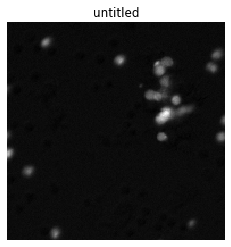

In [44]:
show_image(X_valid[149])

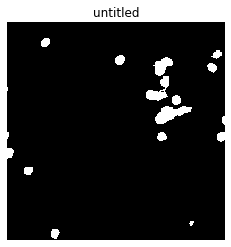

In [43]:
show_image(y_valid[149])

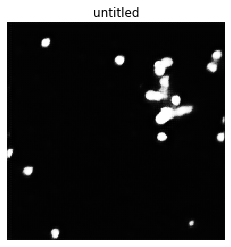

In [40]:
show_image(predictions[149])

In [0]:
model.save('/content/gdrive/My Drive/l4_dataset/unet_base_weights.h5')